# Data Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df_train = pd.read_csv("Training_data/data.csv")
df_test = pd.read_csv("Test_data/data.csv")

In [3]:
img_height = 32
img_width = 248

In [4]:
x_train =[]
y_train = []
x_test = []
y_test = []

In [5]:
for i in range(len(df_train)):
    x_train.append(df_train.iloc[i]["Img_path_name"])
    y_train.append(df_train.iloc[i]["Name"].lower())
    

In [6]:
for i in range(len(df_test)):
    x_test.append(df_test.iloc[i]["Img_path_name"])
    y_test.append(df_test.iloc[i]["Name"].lower())

# Data Preparation


In [7]:
characters = ['a', 'ą', 'b', 'c', 'ć', 'd', 'e', 'ę', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'ł',
              'm', 'n', 'ń', 'o', 'ó', 'p', 'r', 's', 'ś', 't', 'u', 'w', 'y', 'z', 'ź', 'ż']
batch_size = 16
max_len = max([len(label) for label in y_train])

In [8]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=1, mask_token=None
)
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None, invert=True,num_oov_indices=1
)

In [9]:
temp = char_to_num(["j","0","n"])
print (temp)
temp = num_to_char(temp)
print (temp)

tf.Tensor([13  0 18], shape=(3,), dtype=int64)
tf.Tensor([b'j' b'[UNK]' b'n'], shape=(3,), dtype=string)


In [10]:
print(x_train[0],y_train[0])

Training_data/names/img0.jpg arkadiusz


In [11]:
for i in range(len(y_train)):
    for j in range(max_len-len(y_train[i])):
        y_train[i]+="0"
for i in range(len(y_test)):
    for j in range(max_len-len(y_test[i])):
        y_test[i]+="0"
for i in range(10):
    print(y_train[i])
    print(len(y_train[i]))
print(min([len(label) for label in y_train]))

arkadiusz00
11
katarzyna00
11
dorota00000
11
borys000000
11
andrzej0000
11
apolonia000
11
mieczysław0
11
irena000000
11
ignacy00000
11
edmund00000
11
11


In [12]:
char_to_num(tf.strings.unicode_split("test", input_encoding="UTF-8"))

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([26,  7, 24, 26], dtype=int64)>

In [13]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    #print(label)
    #label = pad_sequences([label], maxlen=max_len, padding='post', dtype='int32')
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [15]:
train_dataset.take(1)

<TakeDataset element_spec={'image': TensorSpec(shape=(None, 248, 32, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

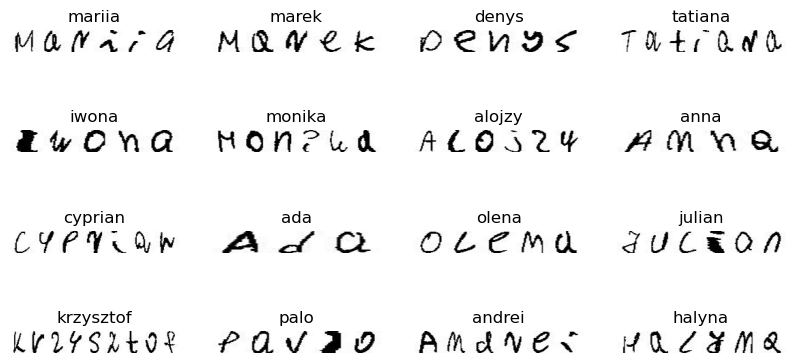

In [16]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in validation_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        label = label.replace("[UNK]","")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Building and Training

In [17]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 2, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 248, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 248, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 124, 16, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 124, 16, 64)  18496       ['pool1[0][0]']       

In [18]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
625/625 [==============================] - 43s 49ms/step - loss: 22.8745 - val_loss: 19.9723
Epoch 2/100
625/625 [==============================] - 25s 41ms/step - loss: 19.6525 - val_loss: 18.2868
Epoch 3/100
625/625 [==============================] - 27s 43ms/step - loss: 17.0649 - val_loss: 14.8641
Epoch 4/100
625/625 [==============================] - 25s 40ms/step - loss: 14.0188 - val_loss: 12.1742
Epoch 5/100
625/625 [==============================] - 25s 41ms/step - loss: 11.2292 - val_loss: 9.6515
Epoch 6/100
625/625 [==============================] - 27s 43ms/step - loss: 8.7859 - val_loss: 7.0892
Epoch 7/100
625/625 [==============================] - 25s 41ms/step - loss: 6.7037 - val_loss: 5.1959
Epoch 8/100
625/625 [==============================] - 27s 42ms/step - loss: 4.8234 - val_loss: 4.0088
Epoch 9/100
625/625 [==============================] - 26s 41ms/step - loss: 3.4153 - val_loss: 2.5373
Epoch 10/100
625/625 [==============================] - 26s 41ms

# Model Testing

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 248, 32, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 248, 32, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 124, 16, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 124, 16, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 62, 8, 64)         0         
                                                                 
 reshape (Reshape)           (None, 62, 512)           0         
                                                                 
 dense1 (Dense)              (None, 62, 64)            32832 

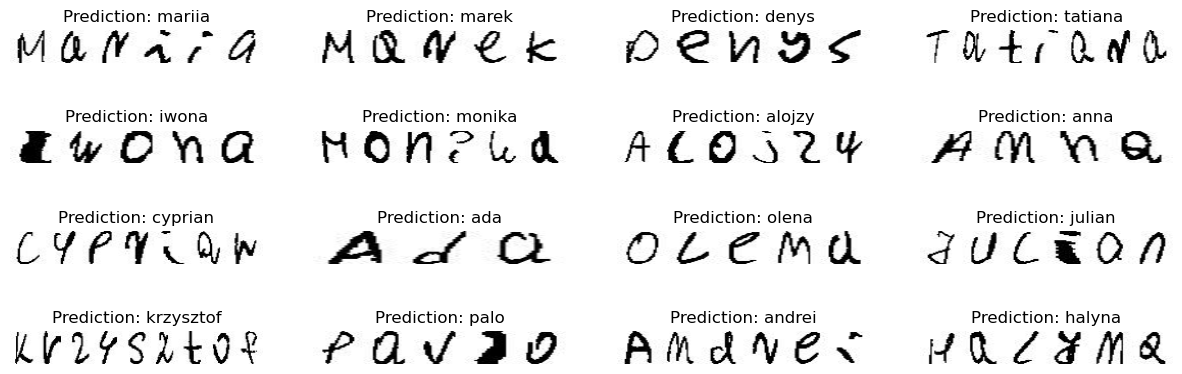

In [19]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        #print("Results")
        #print(res)
        #print(num_to_char(res))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    for i in range(len(pred_texts)):
        pred_texts[i]=pred_texts[i].replace("[UNK]","")
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [23]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [24]:
j=0
acc = 0
similarity = 0
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    for i in range(len(pred_texts)):
        pred_texts[i]=pred_texts[i].replace("[UNK]","0")
        similarity+=similar(pred_texts[i],y_test[j])
        if pred_texts[i]==y_test[j]:
            acc+=1
        j+=1
acc = acc/len(y_test)
similarity = similarity/len(y_test)

In [26]:
print("Accuracy :",acc)
print("Similarity :",similarity)

Accuracy : 0.853
Similarity : 0.982363636363636
